In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import suppress

### run regression model

In [3]:
# load data
cd = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
shp = gpd.read_file(cd + "/icrisat_boundary_match.shp")[['NAME_1', 'Name_12', 'Dist_Name', 'Shape_Area', 'geometry']]
df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
df = df_raw[(df_raw["year"].between(2000, 2022)) & df_raw["yield"].notna() & np.isfinite(df_raw["yield"])]

# Run regression and generate predictions
regs = []
yield_mean = df["yield"].mean(skipna=True)
for (cropname, name_1, name_12), group in df.groupby(["cropname", "NAME_1", "Name_12"]):
    if len(group) >= 10 and not group["sm"].isna().all() and not group["tmax"].isna().all():
        X = group[["sm", "tmax", "year"]].dropna()
        y = np.log(group.loc[X.index, "yield"] + yield_mean)

        model = sm.OLS(y, sm.add_constant(X)).fit()
        predictions = pd.DataFrame({
            "year": X["year"],
            "predicted_yield": np.exp(model.predict(sm.add_constant(X))) - yield_mean
        })

        regs.append({
            "cropname": cropname,
            "NAME_1": name_1,
            "Name_12": name_12,
            "r2": model.rsquared,
            "sm_slope": model.params.get("sm", np.nan),
            "tmax_slope": model.params.get("tmax", np.nan),
            "year_slope": model.params.get("year", np.nan),
            "sm_pval": model.pvalues.get("sm", np.nan),
            "tmax_pval": model.pvalues.get("tmax", np.nan),
            "year_pval": model.pvalues.get("year", np.nan),
            "predictions": predictions
        })

regs_df = pd.DataFrame(regs)
regs_df = regs_df[regs_df["r2"] < 1]  

/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_31608/2797683829.py:4: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


### fxs for plotting

In [4]:
# Define years of interest and crop lists
years_of_interest = [2002, 2009, 2014, 2015, 2018]
crops_list = {
    2002: ["Groundnuts, with shell", "Maize", "Millet", "Soybeans", "Sorghum", "Rice, paddy", "Rapeseed", "Sunflower seed"],
    2009: ["Barley", "Rice, paddy", "Wheat", "Maize", "Sorghum", "Millet", "Soybeans"],
    2014: ["Barley", "Rapeseed", "Wheat"],
    2015: ["Groundnuts, with shell", "Rice, paddy", "Maize", "Sorghum", "Soybeans"],
    2018: ["Sunflower seed", "Groundnuts, with shell", "Rice, paddy", "Maize", "Sorghum", "Millet"]}

# Function to get observed yields
def get_yields(year):
    if year not in crops_list:
        return pd.DataFrame()
    
    return df[(df["year"] == year) & (df["cropname"].isin(crops_list[year]))].groupby(["Name_12", "cropname"], as_index=False)["yield"].mean()

# Function to get predicted yields
def get_predicted_yields(year):
    preds = regs_df.copy()
    
    def extract_yield_from_row(row, year):
        if isinstance(row, pd.DataFrame):  
            return row[row["year"] == year]["predicted_yield"].values[0] if not row[row["year"] == year].empty else None
        return None 
    
    preds["predicted_yield"] = preds["predictions"].apply(lambda x: extract_yield_from_row(x, year))
    preds = preds[preds["cropname"].isin(crops_list[year])]
    
    return preds[["Name_12", "cropname", "predicted_yield"]]

# Function to compute yield differences
def get_diff(yields, predicted):
    return pd.merge(yields, predicted, on=["Name_12", "cropname"], how="left").assign(diff=lambda x: x["yield"] - x["predicted_yield"])

# Function to merge with shapefile
def merge_shp(df):
    return shp.merge(df, on="Name_12", how="left").dropna(subset=["cropname"])

In [5]:
def plot_facet_maps(data, fill_var, title, cmap, vmin, vmax):
    unique_crops = data["cropname"].unique()
    num_crops = len(unique_crops)

    if num_crops == 0:
        print(f"Skipping plot for {title} due to missing data.")
        return

    # Determine grid size for subplots
    cols = min(num_crops, 3)  # Limit to 3 columns
    rows = (num_crops // cols) + (num_crops % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten() if num_crops > 1 else [axes]

    for i, crop in enumerate(unique_crops):
        crop_data = data[data["cropname"] == crop]
        if crop_data.empty:
            continue
        crop_data.plot(column=fill_var, cmap=cmap, linewidth=0.8, edgecolor="black", legend=True, ax=axes[i],  vmin= vmin, vmax=vmax)
        axes[i].set_title(f"{title} - {crop}", fontsize=14)
        axes[i].axis("off")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [8]:
def run_everything(year):
    yields_df = get_yields(year)
    predicted_df = get_predicted_yields(year)
    diff_df = get_diff(yields_df, predicted_df)

    yields = merge_shp(yields_df)
    predicted = merge_shp(predicted_df)
    diff = merge_shp(diff_df)
    
    # Observed Yield Plot
    plot_facet_maps(yields, "yield", f"Observed Yield - {year}", "plasma", vmin=0, vmax=4)
    
    # Predicted Yield Plot
    plot_facet_maps(predicted, "predicted_yield", f"Predicted Yield - {year}", "plasma", vmin=0, vmax=4)
    
    # Yield Difference Plot
    plot_facet_maps(diff, "diff", f"Yield Difference - {year}", "RdBu_r", vmin=-1, vmax=1)


### plots

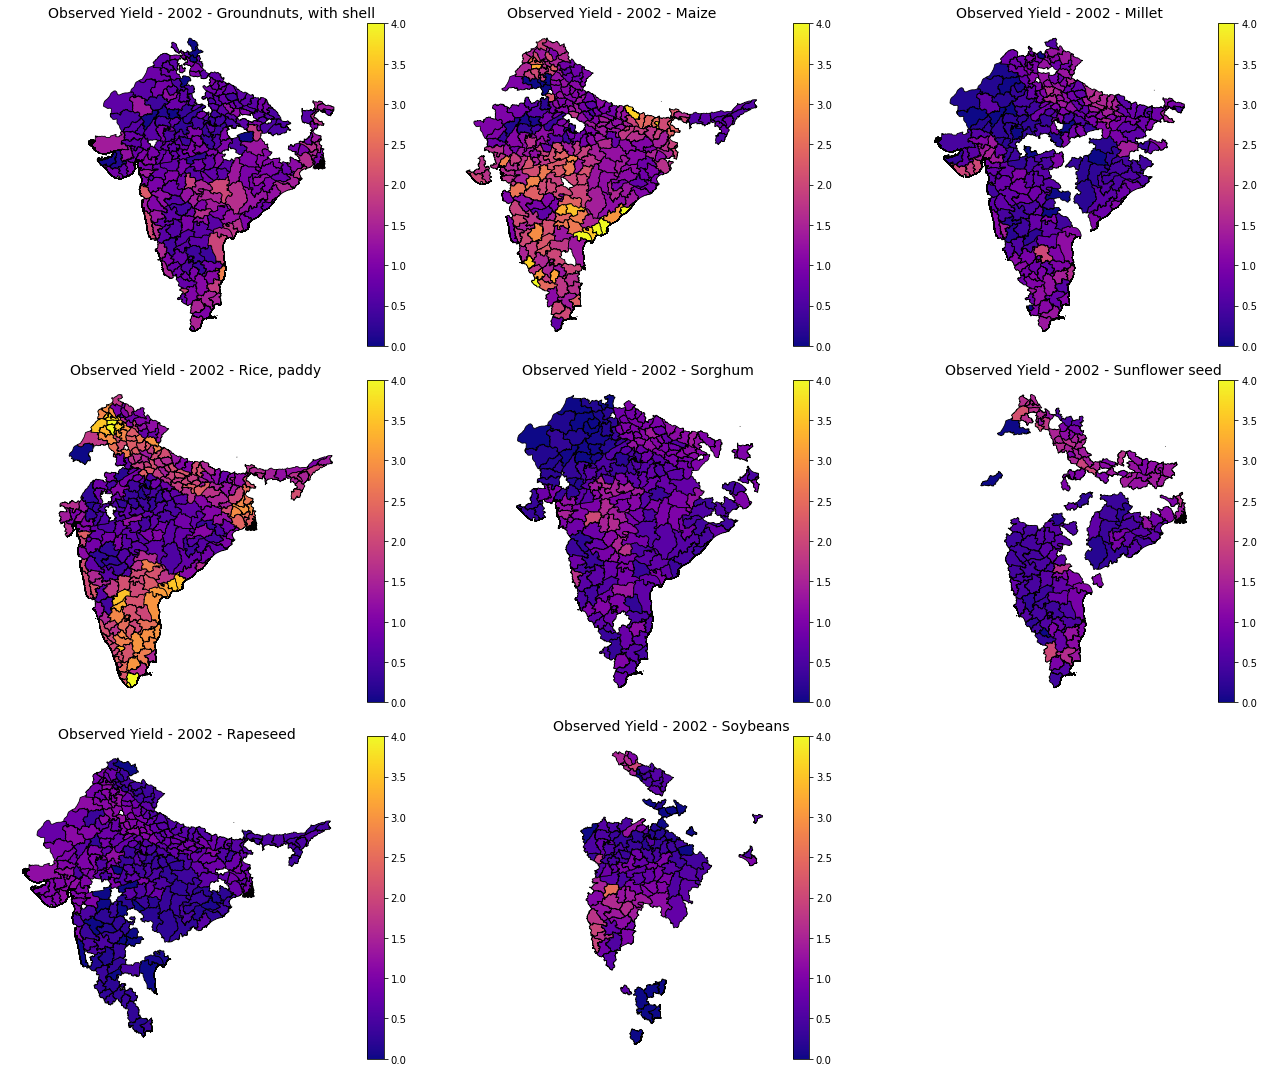

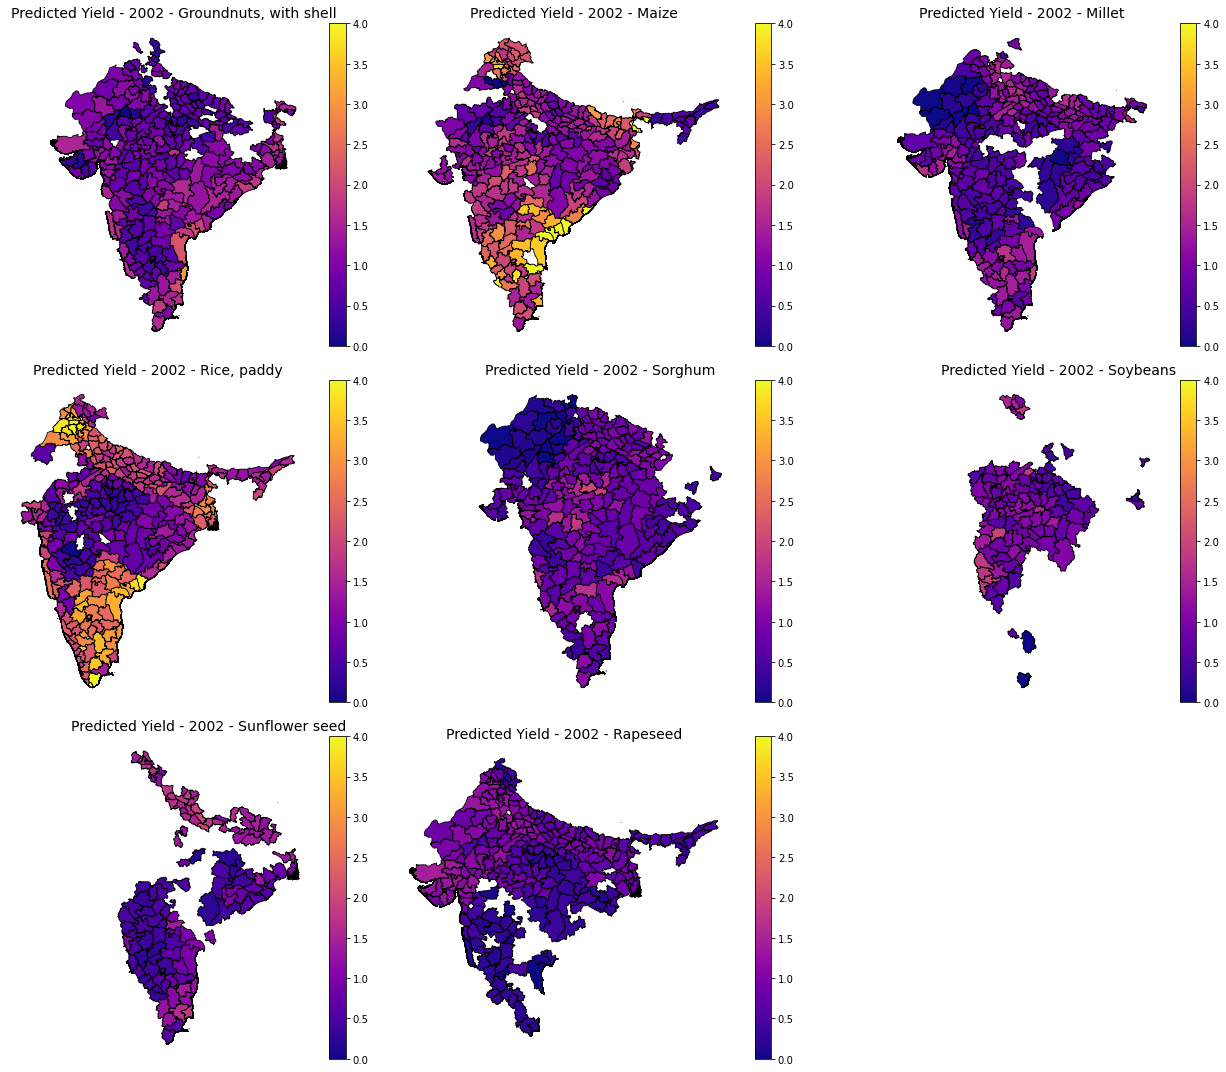

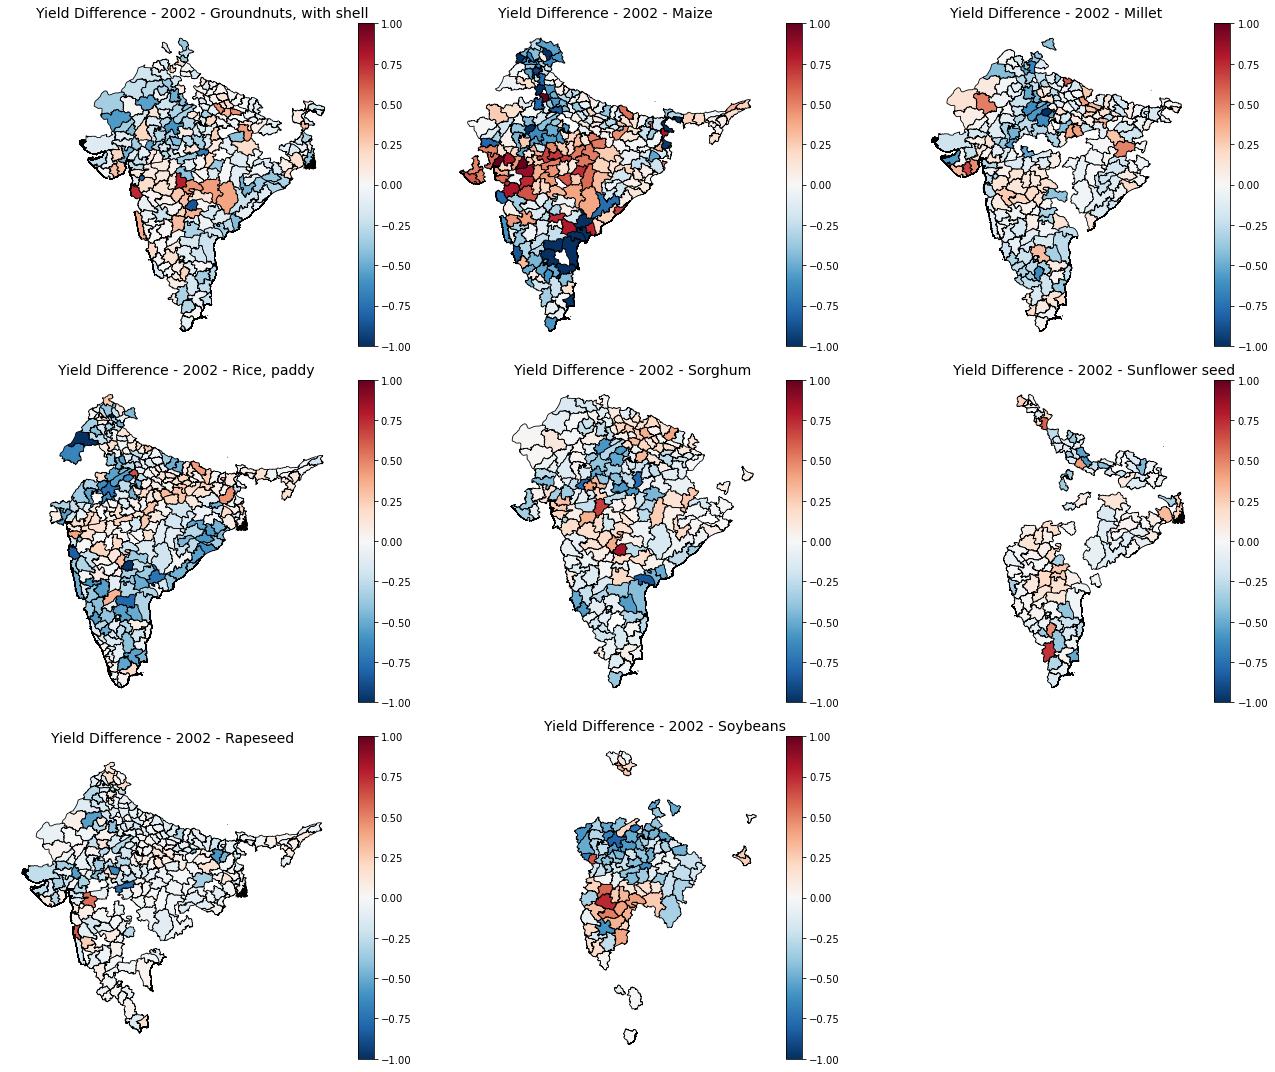

In [9]:
run_everything(2002)

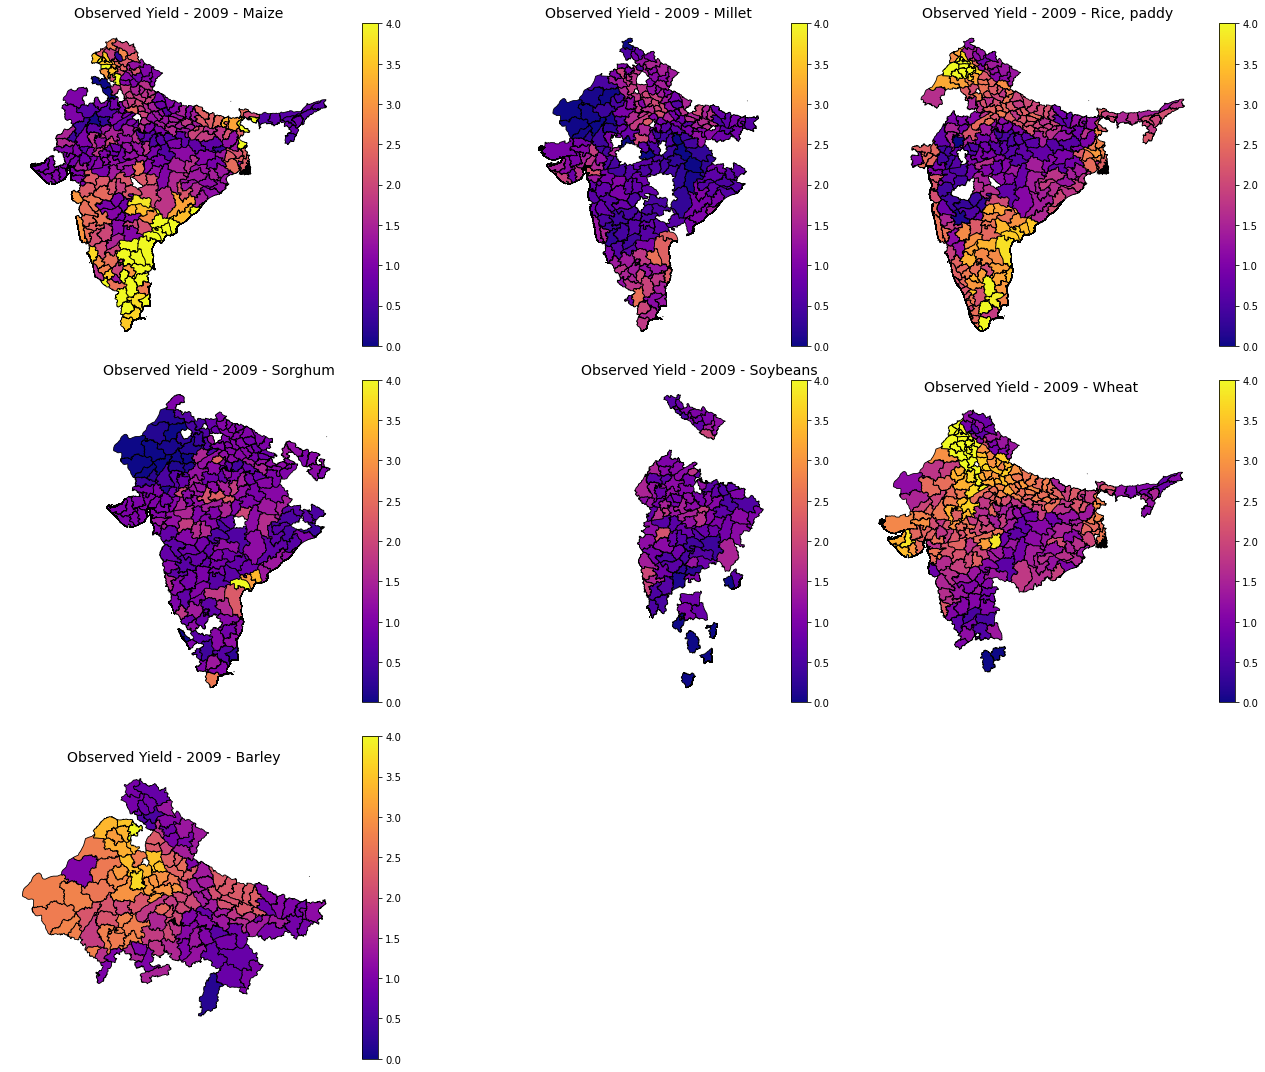

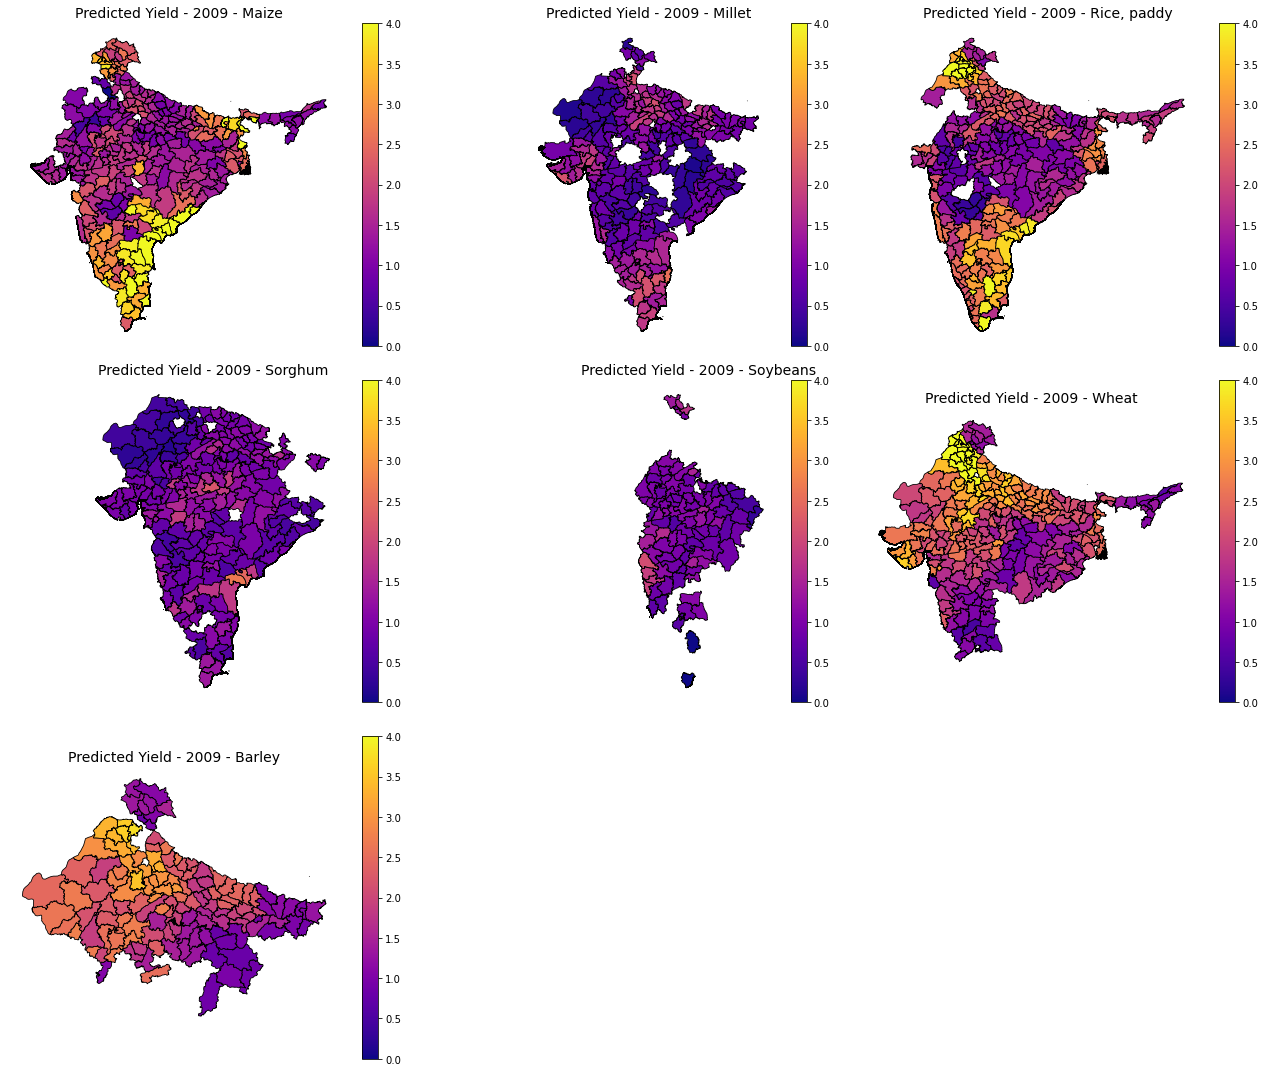

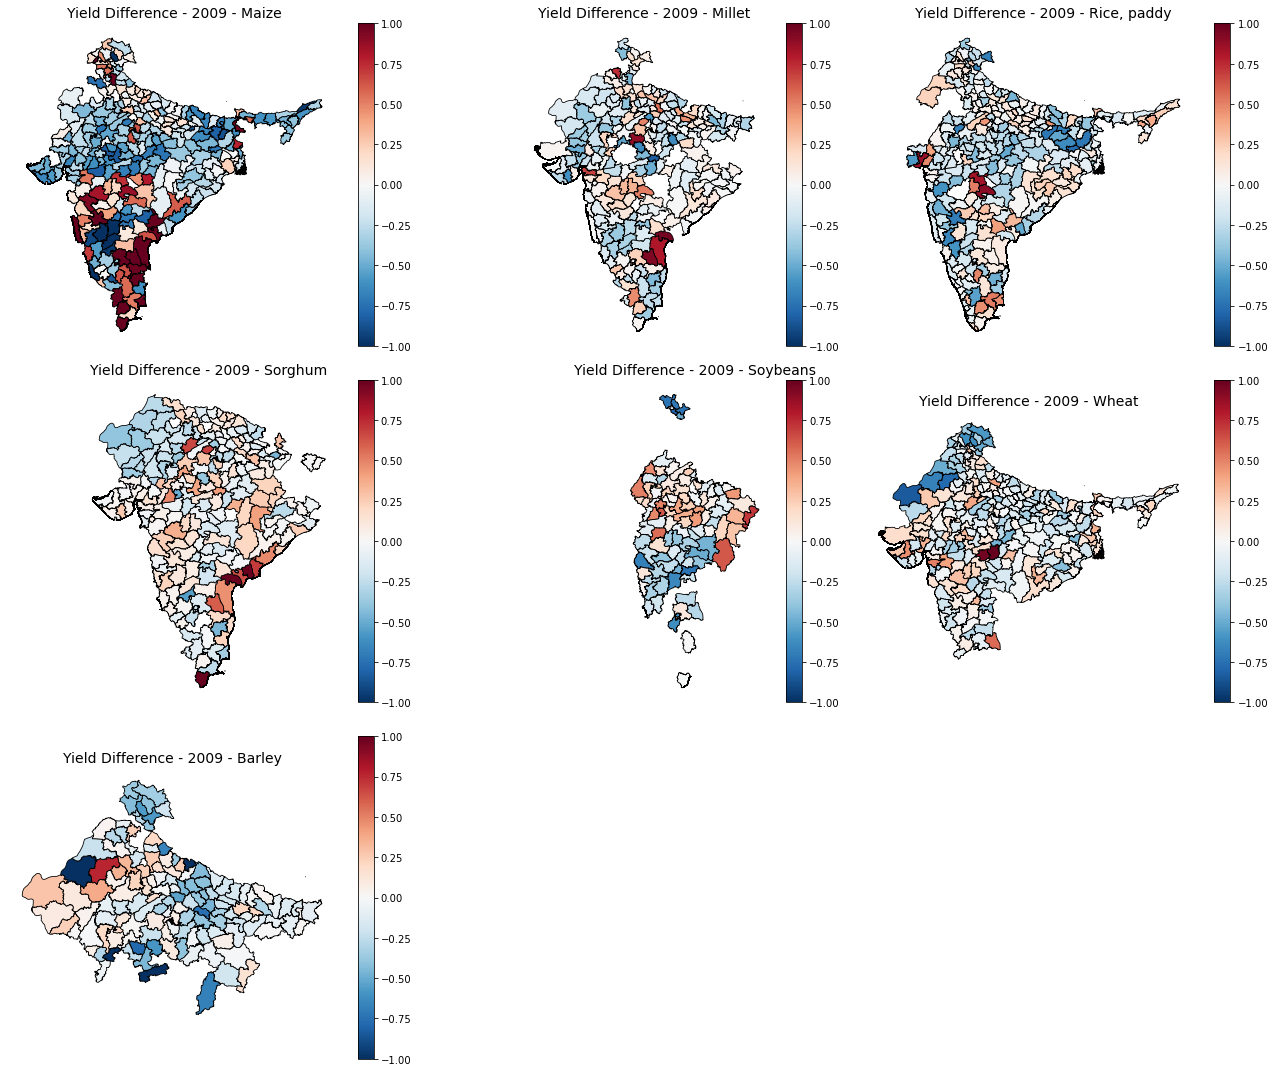

In [10]:
run_everything(2009)

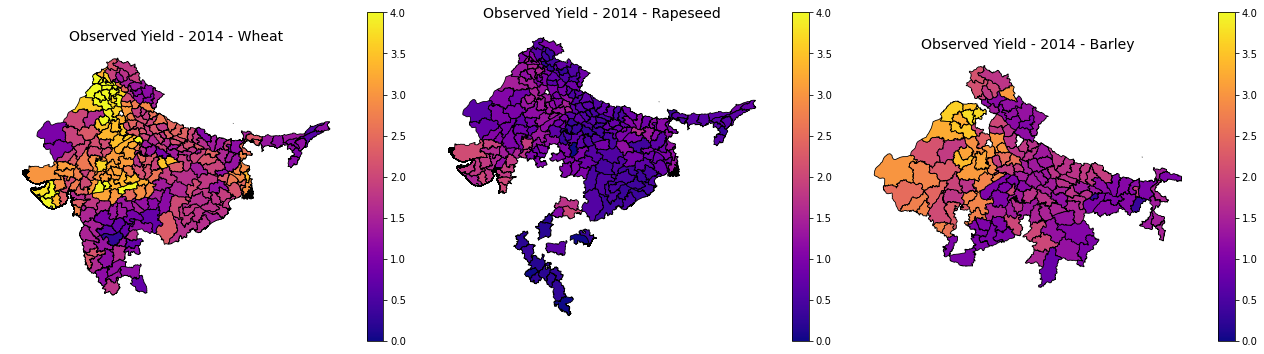

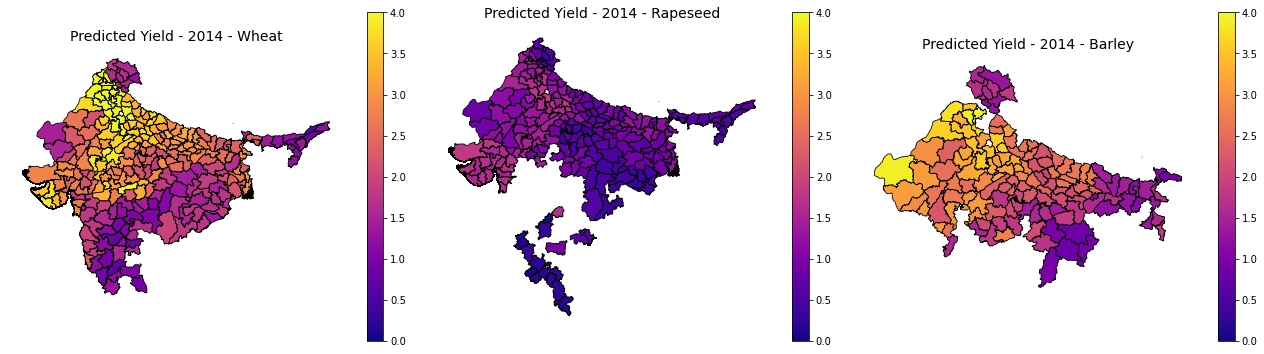

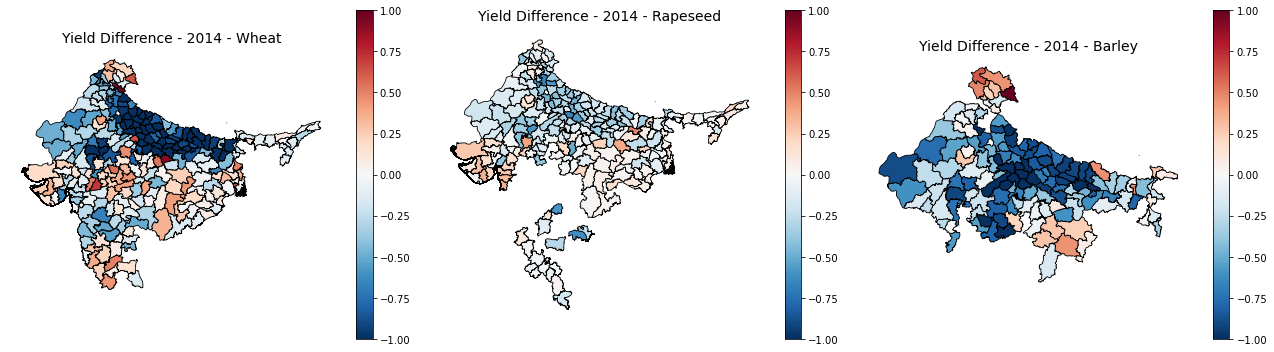

In [11]:
run_everything(2014)

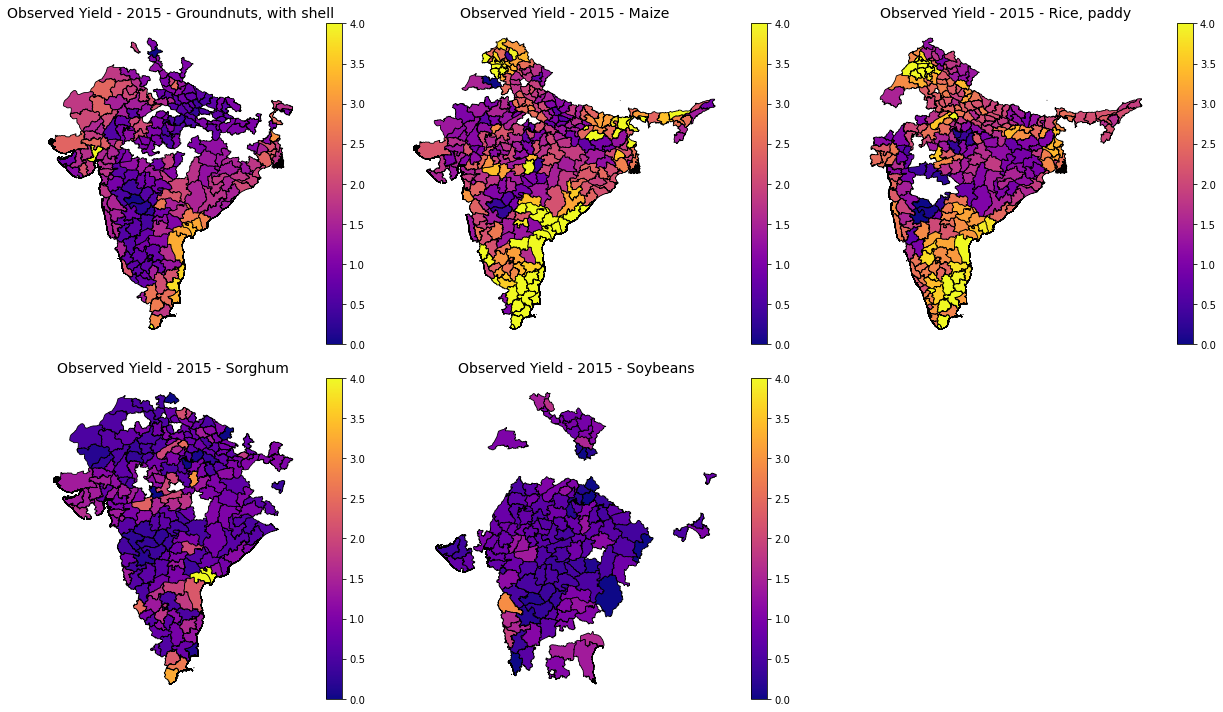

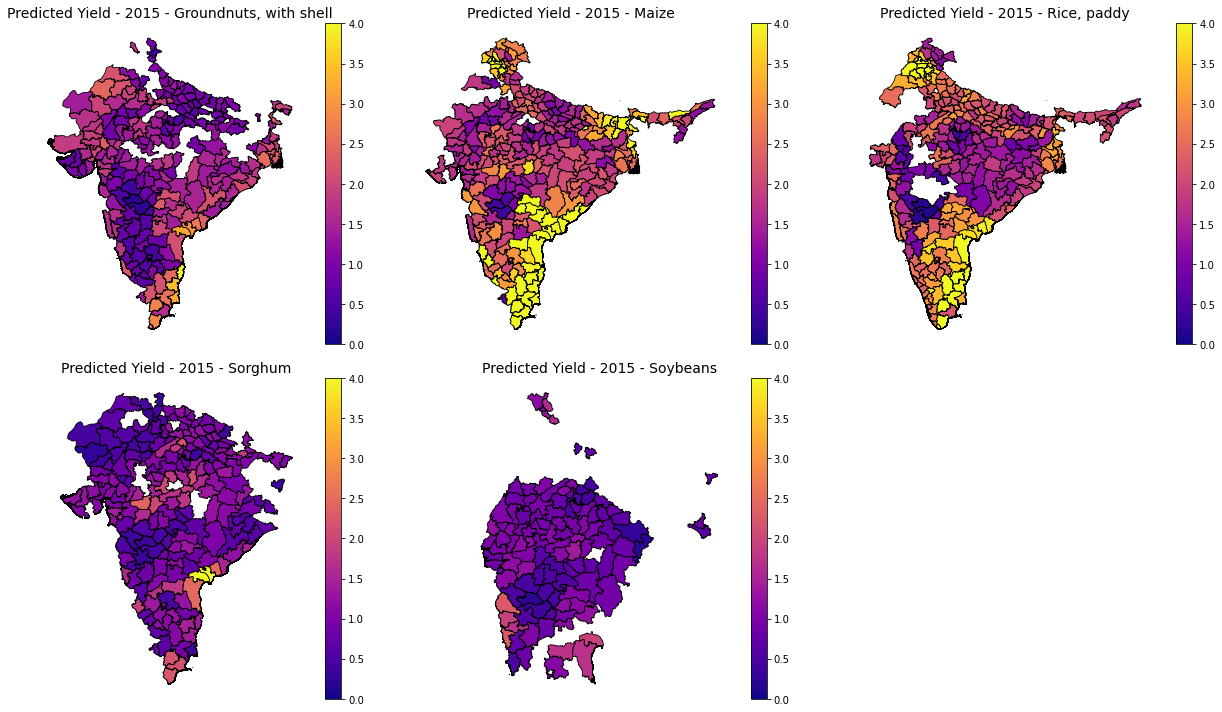

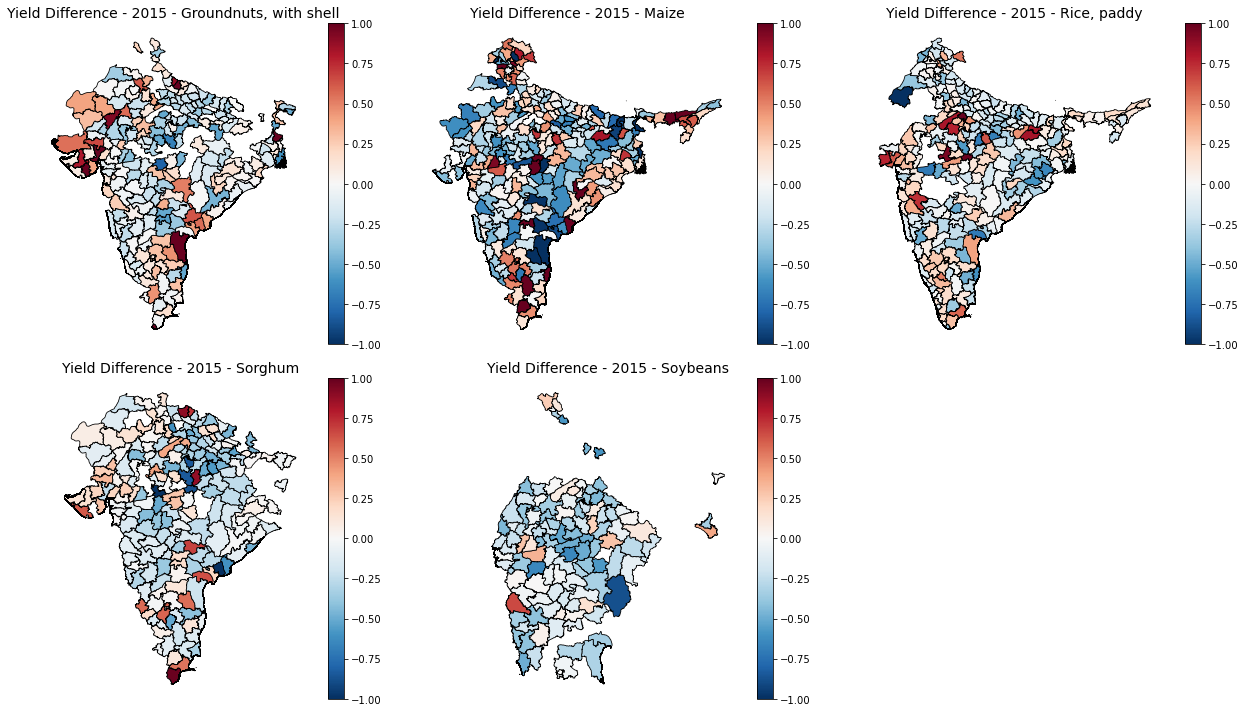

In [12]:
run_everything(2015)

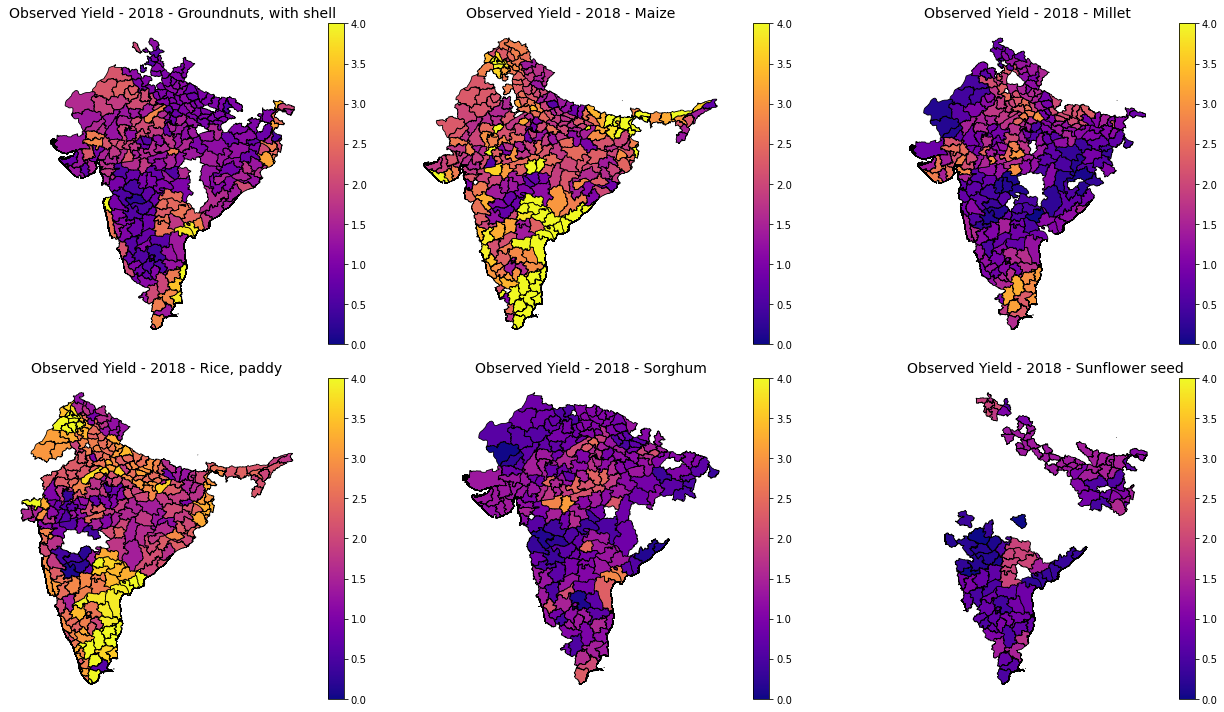

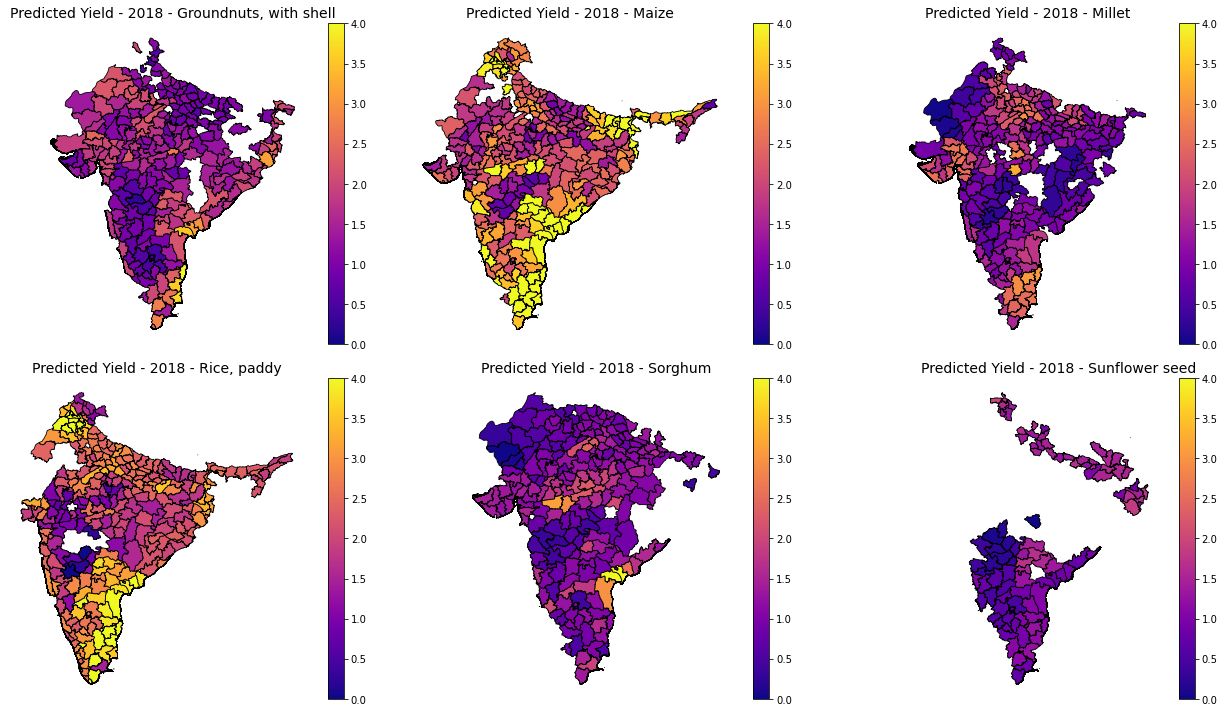

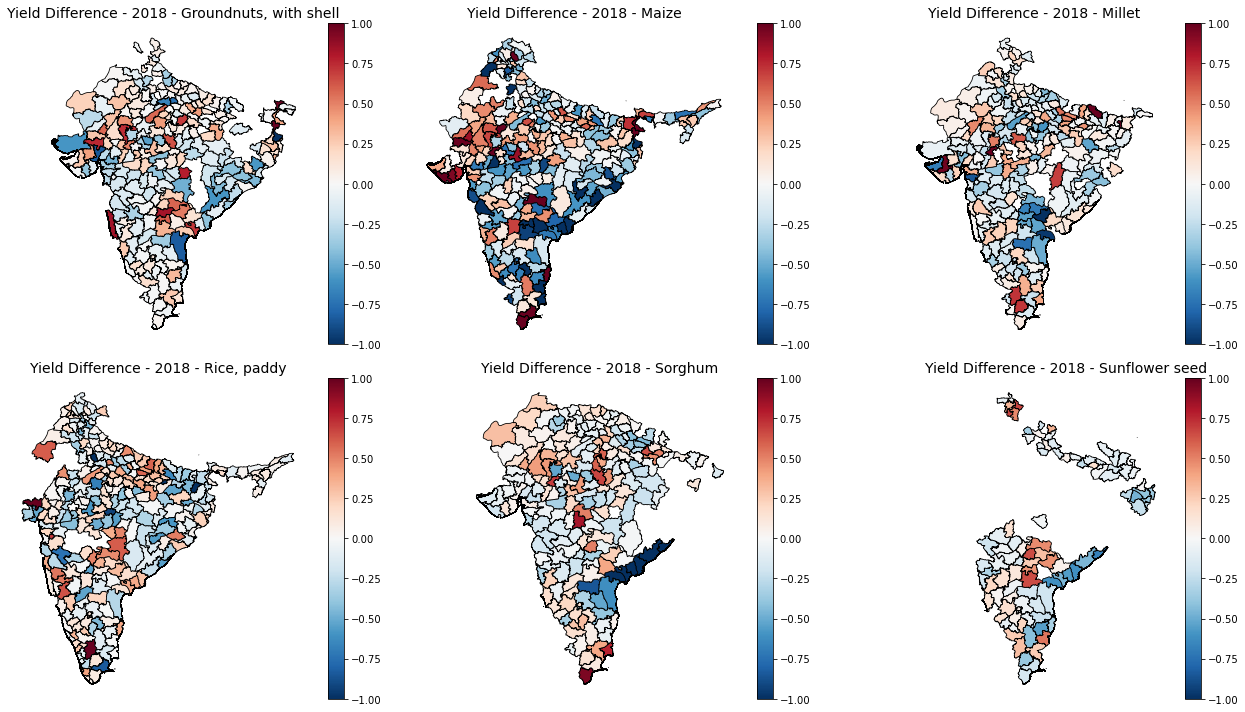

In [13]:
run_everything(2018)